<a href="https://colab.research.google.com/github/ForhanShahriarFahim/NeuronTree.AI/blob/master/Neuron_Activation_Analysis_Taks_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on: cuda


100%|██████████| 170M/170M [00:03<00:00, 49.1MB/s]


Loading Pre-trained VGG16 (CIFAR-10)...


/usr/local/lib/python3.12/dist-packages/torch/hub.py:335: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/vgg/cifar10_vgg16_bn-6ee7ea24.pt" to /root/.cache/torch/hub/checkpoints/cifar10_vgg16_bn-6ee7ea24.pt


100%|██████████| 58.3M/58.3M [00:01<00:00, 46.2MB/s]


Analyzing Neuron #125 on 10,000 images...

--- Results ---
Class plane: 0.0387
Class car: 0.8391
Class bird: 0.0484
Class cat: 0.3221
Class deer: 0.0873
Class dog: 0.0208
Class frog: 0.0858
Class ship: 0.8992
Class truck: 1.0862


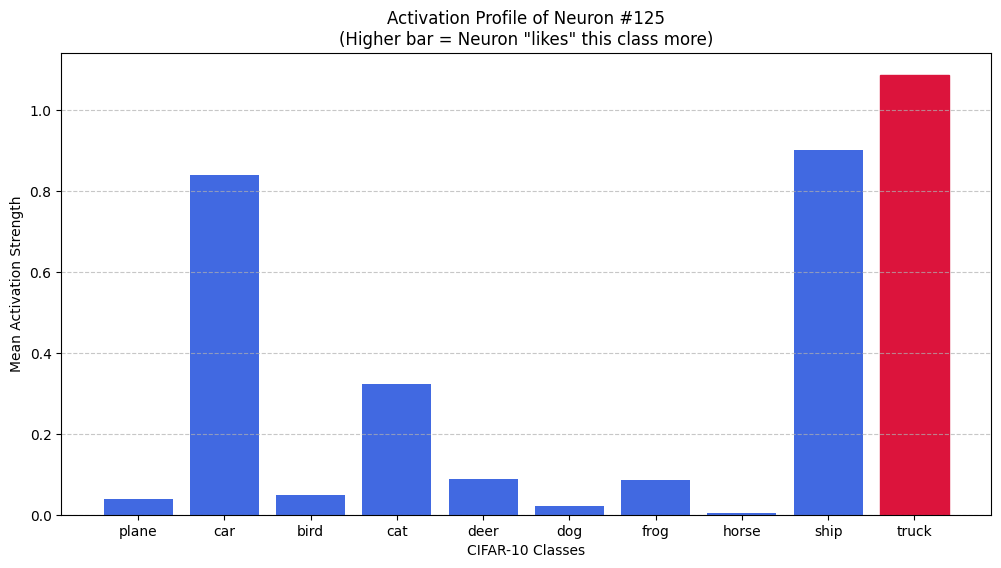

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# --- COLAB CONFIGURATION ---
# 1. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# 2. TARGET SETTINGS
# In VGG16 (CIFAR version), the classifier usually has sizes: 512 -> 512 -> 10
# We will look at the neuron in the layer BEFORE the final class output.
TARGET_LAYER_INDEX = 4   # This varies by model implementation, usually a ReLU or Linear
TARGET_NEURON_INDEX = 125 # Let's check Neuron #125
BATCH_SIZE = 128         # Increased for GPU speed

# --- DATA PREPARATION ---
print("Downloading CIFAR-10 Data...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

# --- MODEL SETUP ---
print("Loading Pre-trained VGG16 (CIFAR-10)...")
# We use a specific repo that has VGG16 trained on CIFAR-10
# Standard torchvision VGG16 is for ImageNet (1000 classes), which breaks the analysis
try:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
except:
    print("Hub load failed, loading standard (untrained) VGG16 as fallback.")
    model = torchvision.models.vgg16(num_classes=10)

model = model.to(device)
model.eval()

# --- THE HOOK ---
activations = {}

def get_activation(name):
    def hook(model, input, output):
        # Detach and move to CPU immediately to save GPU memory
        activations[name] = output.detach()
    return hook

# Register hook to the second-to-last Linear layer's ReLU
# Structure: (classifier): Sequential( (0): Linear... (1): ReLU... (3): Linear... (4): ReLU... )
model.classifier[4].register_forward_hook(get_activation('target_layer'))

# --- ANALYSIS LOOP ---
class_activations = {i: [] for i in range(10)}
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Analyzing Neuron #{TARGET_NEURON_INDEX} on 10,000 images...")

with torch.no_grad():
    for images, labels in testloader:
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        _ = model(images)

        # Get activations (shape: [Batch_Size, 4096] or [Batch_Size, 512] depending on variant)
        layer_output = activations['target_layer']

        # Check if our neuron index exists (some CIFAR VGGs are smaller)
        if TARGET_NEURON_INDEX >= layer_output.shape[1]:
            print(f"Error: Neuron Index {TARGET_NEURON_INDEX} is out of bounds for layer size {layer_output.shape[1]}")
            break

        # Select the specific neuron
        neuron_values = layer_output[:, TARGET_NEURON_INDEX]

        # Store values (move back to CPU for list storage)
        for val, label in zip(neuron_values, labels):
            class_activations[label.item()].append(val.item())

# --- PLOTTING ---
mean_activations = []
print("\n--- Results ---")
for i in range(10):
    vals = class_activations[i]
    if len(vals) > 0:
        mean_val = np.mean(vals)
    else:
        mean_val = 0.0
    mean_activations.append(mean_val)
    # Print only if the neuron actually fired
    if mean_val > 0.01:
        print(f"Class {classes[i]}: {mean_val:.4f}")

plt.figure(figsize=(12, 6))
bars = plt.bar(classes, mean_activations, color='royalblue')
plt.title(f'Activation Profile of Neuron #{TARGET_NEURON_INDEX}\n(Higher bar = Neuron "likes" this class more)')
plt.ylabel('Mean Activation Strength')
plt.xlabel('CIFAR-10 Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the max class
max_val = max(mean_activations)
if max_val > 0:
    max_idx = mean_activations.index(max_val)
    bars[max_idx].set_color('crimson')

plt.show()

Finding Top 5 images for Neuron #125...


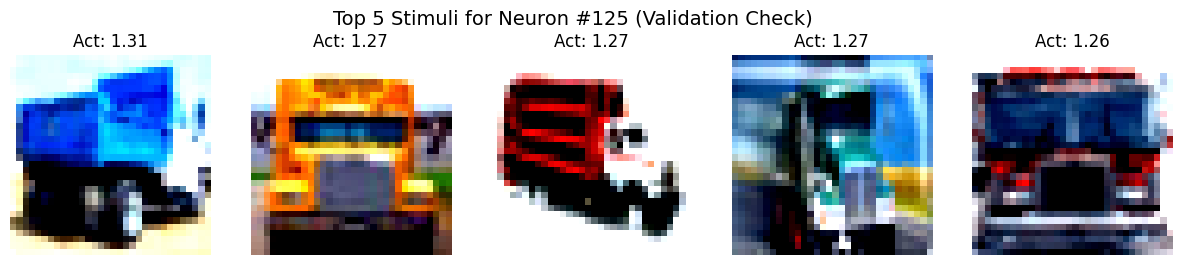

In [ ]:
# --- VALIDATION: VISUALIZE TOP ACTIVATING IMAGES ---
import heapq

# 1. Re-run or modify the loop to capture (activation, image) pairs
# We use a min-heap to keep track of the Top 5 efficiently
top_5_activations = []  # Stores tuples: (activation_value, image_tensor)

print(f"Finding Top 5 images for Neuron #{TARGET_NEURON_INDEX}...")

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        _ = model(images)

        # Get activations
        layer_output = activations['target_layer']
        neuron_values = layer_output[:, TARGET_NEURON_INDEX]

        # Check every image in the batch
        for i in range(images.size(0)):
            val = neuron_values[i].item()
            img = images[i].cpu() # Move image back to CPU for storage

            # Logic to keep only top 5
            if len(top_5_activations) < 5:
                heapq.heappush(top_5_activations, (val, img))
            else:
                # If current val is larger than the smallest in our top 5, replace it
                if val > top_5_activations[0][0]:
                    heapq.heapreplace(top_5_activations, (val, img))

# 2. Plot the Top 5 Images
top_5_activations.sort(key=lambda x: x[0], reverse=True) # Sort high to low

plt.figure(figsize=(15, 3))
plt.suptitle(f"Top 5 Stimuli for Neuron #{TARGET_NEURON_INDEX} (Validation Check)", fontsize=14)

for i, (val, img) in enumerate(top_5_activations):
    plt.subplot(1, 5, i+1)

    # Un-normalize image for display (CIFAR-10 specific)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.title(f"Act: {val:.2f}")
    plt.axis('off')

plt.show()